In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1: Reading the dataset

In [2]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [3]:
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### Step 2: Perform data quality checks

In [4]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

In [5]:
df.duplicated().sum()

0

### Step 3: Seperate X and Y(Profit)

In [6]:
X = df.drop(columns=['PROFIT'])
Y = df[['PROFIT']]

In [10]:
X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [11]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


### Step 4: Perform Preprocessing on X

In [12]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [13]:
cat

['STATE']

In [14]:
con

['RND', 'ADMIN', 'MKT']

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [17]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [18]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [19]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


### Step 5: Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=42)

In [21]:
xtrain.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
12,0.443260,0.215449,0.320617,0.0,1.0,0.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0
37,-0.652532,-2.525994,-0.115608,1.0,0.0,0.0
8,1.030369,0.986952,0.830887,0.0,0.0,1.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0


In [23]:
ytrain.head()

,PROFIT
12,141585.52
4,166187.94
37,89949.14
8,152211.77
3,182901.99


In [24]:
xtest.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
13,0.402078,0.510179,0.343957,1.0,0.0,0.0
39,-0.773820,-1.383122,-0.297583,1.0,0.0,0.0
30,-0.258074,-0.205629,-0.990357,0.0,1.0,0.0
45,-1.600350,0.101254,-1.727400,0.0,0.0,1.0
17,0.460720,0.855666,0.591017,0.0,0.0,1.0


In [25]:
ytest.head()

,PROFIT
13,134307.35
39,81005.76
30,99937.59
45,64926.08
17,125370.37


In [26]:
xtrain.shape

(40, 6)

In [27]:
xtest.shape

(10, 6)

### Step 6: Create a Decision Tree Model

In [28]:
from sklearn.tree import DecisionTreeRegressor
model1 = DecisionTreeRegressor(max_depth=1,
                               min_samples_split=5,
                               min_samples_leaf=5,
                               criterion='absolute_error')
model1.fit(xtrain, ytrain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=1,
                      min_samples_leaf=5, min_samples_split=5)

In [29]:
model1.score(xtrain, ytrain)

0.6422391424192635

In [30]:
model1.score(xtest, ytest)

-0.01325670077998109

### Step 7: Hyperparameter Tune the moel GridSearchCV

In [31]:
params = {'max_depth':[1, 2, 3, 4, 5, 6, 7],
          'min_samples_split':[3, 4, 5, 6, 7],
          'min_samples_leaf':[5, 6, 7, 8, 9],
          'criterion':['absolute_error', 'squared_error']}

In [32]:
from sklearn.model_selection import GridSearchCV
dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, param_grid=params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [5, 6, 7, 8, 9],
                         'min_samples_split': [3, 4, 5, 6, 7]},
             scoring='neg_mean_squared_error')

In [33]:
gscv.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 3}

In [34]:
gscv.best_score_

-220988080.8887466

In [35]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=3)

### Evaluate the model

In [36]:
best_dtr.score(xtrain, ytrain)

0.92488744498642

In [37]:
best_dtr.score(xtest, ytest)

0.8348355676233886

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(model, x, y):
    ypred=model.predict(x)
    mse = mean_squared_error(y, ypred)
    rmse = mse**(1/2)
    mae = mean_absolute_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f'Mean Squared Error : {mse:.2f}')
    print(f'Root Mean Squared Error : {rmse:.2f}')
    print(f'Mean Absolute Error : {mae:.2f}')
    print(f'R2 Score : {r2:.4f}')

In [39]:
evaluate_model(best_dtr, xtrain, ytrain)

Mean Squared Error : 129303103.51
Root Mean Squared Error : 11371.15
Mean Absolute Error : 8177.11
R2 Score : 0.9249


In [40]:
evaluate_model(best_dtr, xtest, ytest)

Mean Squared Error : 133748848.20
Root Mean Squared Error : 11564.98
Mean Absolute Error : 9895.47
R2 Score : 0.8348


### Plot the tree

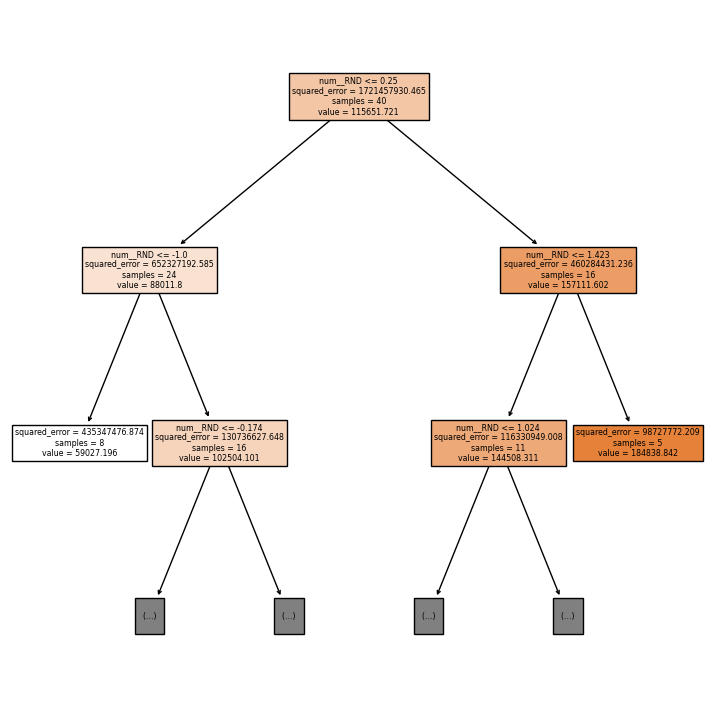

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
plot_tree(best_dtr, feature_names=xtrain.columns, filled=True, max_depth=2)
plt.show()